z4271698 Zhaoyan Liu

# Introduction
In the modern world, driving is one of the most essential modes of transportation. In order to prevent drivers from disobeying traffic signs, avoid dangers, and promote safer driving, this computer vision project focuses on developing generic CNN model that employ forward-sensing cameras to recognise traffic signals. 

# Data Sources 

Source: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign <br /> Description: For this project, we will use this GTSRB - German Traffic Sign Recognition Benchmark dataset. This is because it is large, lifelike database and contains 43 classes of images and more than 50,000 images. In addition, the images are in RGB with 30x30 pixels and the test folder contains 12.6k images. What's more, the size of images is between 30 x 25 and 266 x 232. 

 

## Exploratory Analysis of Data or RL Tasks: 
This dataset contains 43 classes of images and more than 50,000 images. In addition, the images are in RGB with 30x30 pixels and the test folder contains 12.6k images. The size of images are between 30 x 25 and 266 x 232.

The number of training images of all the classes are shown in the figure. The difference between the least number of class images of "Dangerous Curve Left" and the largest number of class images of "Speed limit (50km/h)" is around 2000, which is not very significant compared to the number of the total images (50,000). Thus, resampling is not neccessary in this dataset.

Challenging Aspect:
There is one challenging aspect which is the different size of the images. When the image size is set to be 266 x 232, the training will be broken. This is because the longer time processing for large images and the RAM memoory limitation. Thus to solve this challenge, resizing the iamge to 30 x 30 is necessary for increasing the training speed and maintaining the test accuracy

In [ ]:
# fixed constant for size (image size may be different for diffent models)
HEIGHT = 30
WIDTH = 30

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os

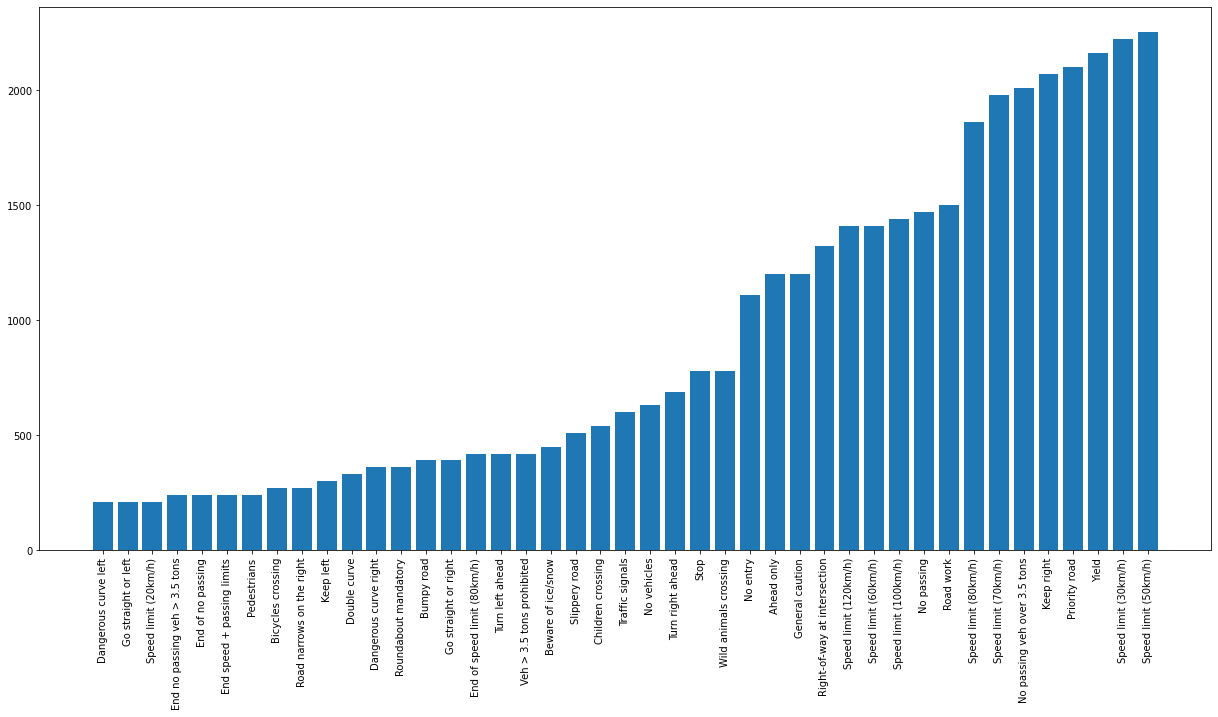

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

trainFolder = '/kaggle/input/gtsrb-german-traffic-sign/Train'
trainFolders = os.listdir(trainFolder)

trainNumber = []
classNum = []

for folder in trainFolders:
    trainFiles = os.listdir(trainFolder + '/' + folder)
    trainNumber.append(len(trainFiles))
    classNum.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipList = zip(trainNumber, classNum)
sortedPairs = sorted(zipList)
tuples = zip(*sortedPairs)
trainNumber, classNum = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(classNum, trainNumber)
plt.xticks(classNum, rotation='vertical')
plt.show()

### Read data for training

In [ ]:
trainData = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Train.csv', usecols=['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId'])

features = []
for feature in trainData.columns:
    if feature != 'ClassId':
        features.append(feature)
X = trainData[features]
y = np.array(trainData['ClassId'])

# Read all folders in the folderPath and combine the files together into a list
fileList = []
for i in range(43) :
    path = "/kaggle/input/gtsrb-german-traffic-sign/train/{0}/".format(i)
    trainFiles = os.listdir(path)
    for img in trainFiles:
        try:
            image=cv2.imread(path + img)
            # Convert array to image
            image_f = Image.fromarray(image, 'RGB')
            # resize the image accoding to diffent model
            size_image = image_f.resize((HEIGHT, WIDTH))
            fileList.append(np.array(size_image))
        except:
             print("Error in " + img)
                
image_data = np.array(fileList)
print(image_data.shape, y.shape)

(39209, 30, 30, 3) (39209,)


In [ ]:
# shuffling
sf_i = np.arange(image_data.shape[0])
np.random.seed(43)
np.random.shuffle(sf_i)
image_data = image_data[sf_i]
y = y[sf_i]

# Splitting training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_data, y, test_size=0.2, random_state=42, shuffle=True)
X_train = X_train/255 
X_test = X_test/255
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Hot encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


# Models and Methods：
A CNN is a neural network model that allows us to extract a higher representation of the content of an image. Unlike classical image recognition, a CNN defines its own image features, it takes the raw pixel data of the image, trains the model and then automatically extracts the features for better classification.  

In our model, the structure starts with 2 consecutive convolutional layers to extract and learn the features and pass them to the pooling layer, replacing the output with the maximum summary using the maximum pool to reduce the data size and processing time. The above structure is then repeated, followed by a convolutional layer, a pooling layer and a normalization layer for stable training, the corresponding results are flattened, dropout and normalization to effectively prevent overfitting of the training data, and the results are passed to the fully connected layer. And the final output layer will produce 43 classified results. 

Regarding the key model parameters, for the generic CNN model we will test with different values of filter, kernel size and pool size, allowing zero padding and all dense layers will have 'Relu' activation. Higher accuracy is guaranteed by increasing or decreasing the dropout and normalization layer.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Normalization

cnn = Sequential([
    # cnn
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(HEIGHT, WIDTH, 3)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Normalization(),
    
    Flatten(),
    Dense(256, activation='relu'),
    Normalization(),
    Dropout(rate=0.5),
    Dense(43, activation='softmax')
])

In [ ]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10
history = cnn.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/10
981/981 [==============================] - 36s 36ms/step - loss: 1.6763 - accuracy: 0.4947 - val_loss: 0.6350 - val_accuracy: 0.7924
Epoch 2/10
981/981 [==============================] - 34s 35ms/step - loss: 0.5873 - accuracy: 0.7873 - val_loss: 0.4427 - val_accuracy: 0.8262
Epoch 3/10
981/981 [==============================] - 33s 34ms/step - loss: 0.4723 - accuracy: 0.8183 - val_loss: 0.4260 - val_accuracy: 0.8386
Epoch 4/10
981/981 [==============================] - 33s 34ms/step - loss: 0.4332 - accuracy: 0.8273 - val_loss: 0.4107 - val_accuracy: 0.8386
Epoch 5/10
981/981 [==============================] - 33s 33ms/step - loss: 0.4185 - accuracy: 0.8316 - val_loss: 0.3906 - val_accuracy: 0.8434
Epoch 6/10
981/981 [==============================] - 32s 33ms/step - loss: 0.4032 - accuracy: 0.8365 - val_loss: 0.3898 - val_accuracy: 0.8414
Epoch 7/10
981/981 [==============================] - 33s 34ms/step - loss: 0.4003 - accuracy: 0.8377 - val_loss: 0.4024 - val_accuracy:

# Results

#### plot the accuracy and loss of train and validation 

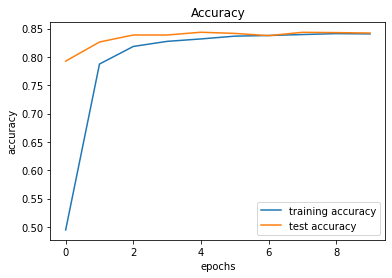

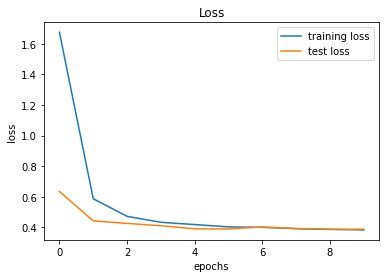

In [ ]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#### loading test and evaluate model

In [ ]:
testData = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
test_imgs = testData["Path"].values
test_labels = testData["ClassId"].values

# Read all folders in the folderPath and combine the files together into a list
fileList = []
for img in test_imgs:
    image = cv2.imread('/kaggle/input/gtsrb-german-traffic-sign/' + img)
    # Convert array to image
    image_f = Image.fromarray(image, 'RGB')
    # resize the image accoding to diffent model
    size_image = image_f.resize((HEIGHT, WIDTH))
    fileList.append(np.array(size_image))

In [ ]:
x_test = np.array(fileList)
x_test = x_test.astype('float32') /255
y_predict = np.argmax(cnn.predict(x_test), axis=1)

from sklearn.metrics import accuracy_score
print('Test accuracy: ', accuracy_score(test_labels, y_predict))

Test accuracy:  0.8873317498020586


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.98      0.98      0.98       720
           2       0.90      0.99      0.94       750
           3       0.88      0.96      0.92       450
           4       0.97      0.96      0.97       660
           5       0.79      0.89      0.84       630
           6       0.00      0.00      0.00       150
           7       0.99      0.90      0.94       450
           8       0.95      0.92      0.94       450
           9       0.96      0.99      0.98       480
          10       0.96      0.97      0.96       660
          11       0.95      0.92      0.93       420
          12       0.98      0.96      0.97       690
          13       0.74      0.99      0.85       720
          14       0.63      0.18      0.28       270
          15       0.49      0.71      0.58       210
          16       0.10      0.01      0.02       150
          17       0.81    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we can see from the results above, the CNN produced a very high accuracy - 92%.

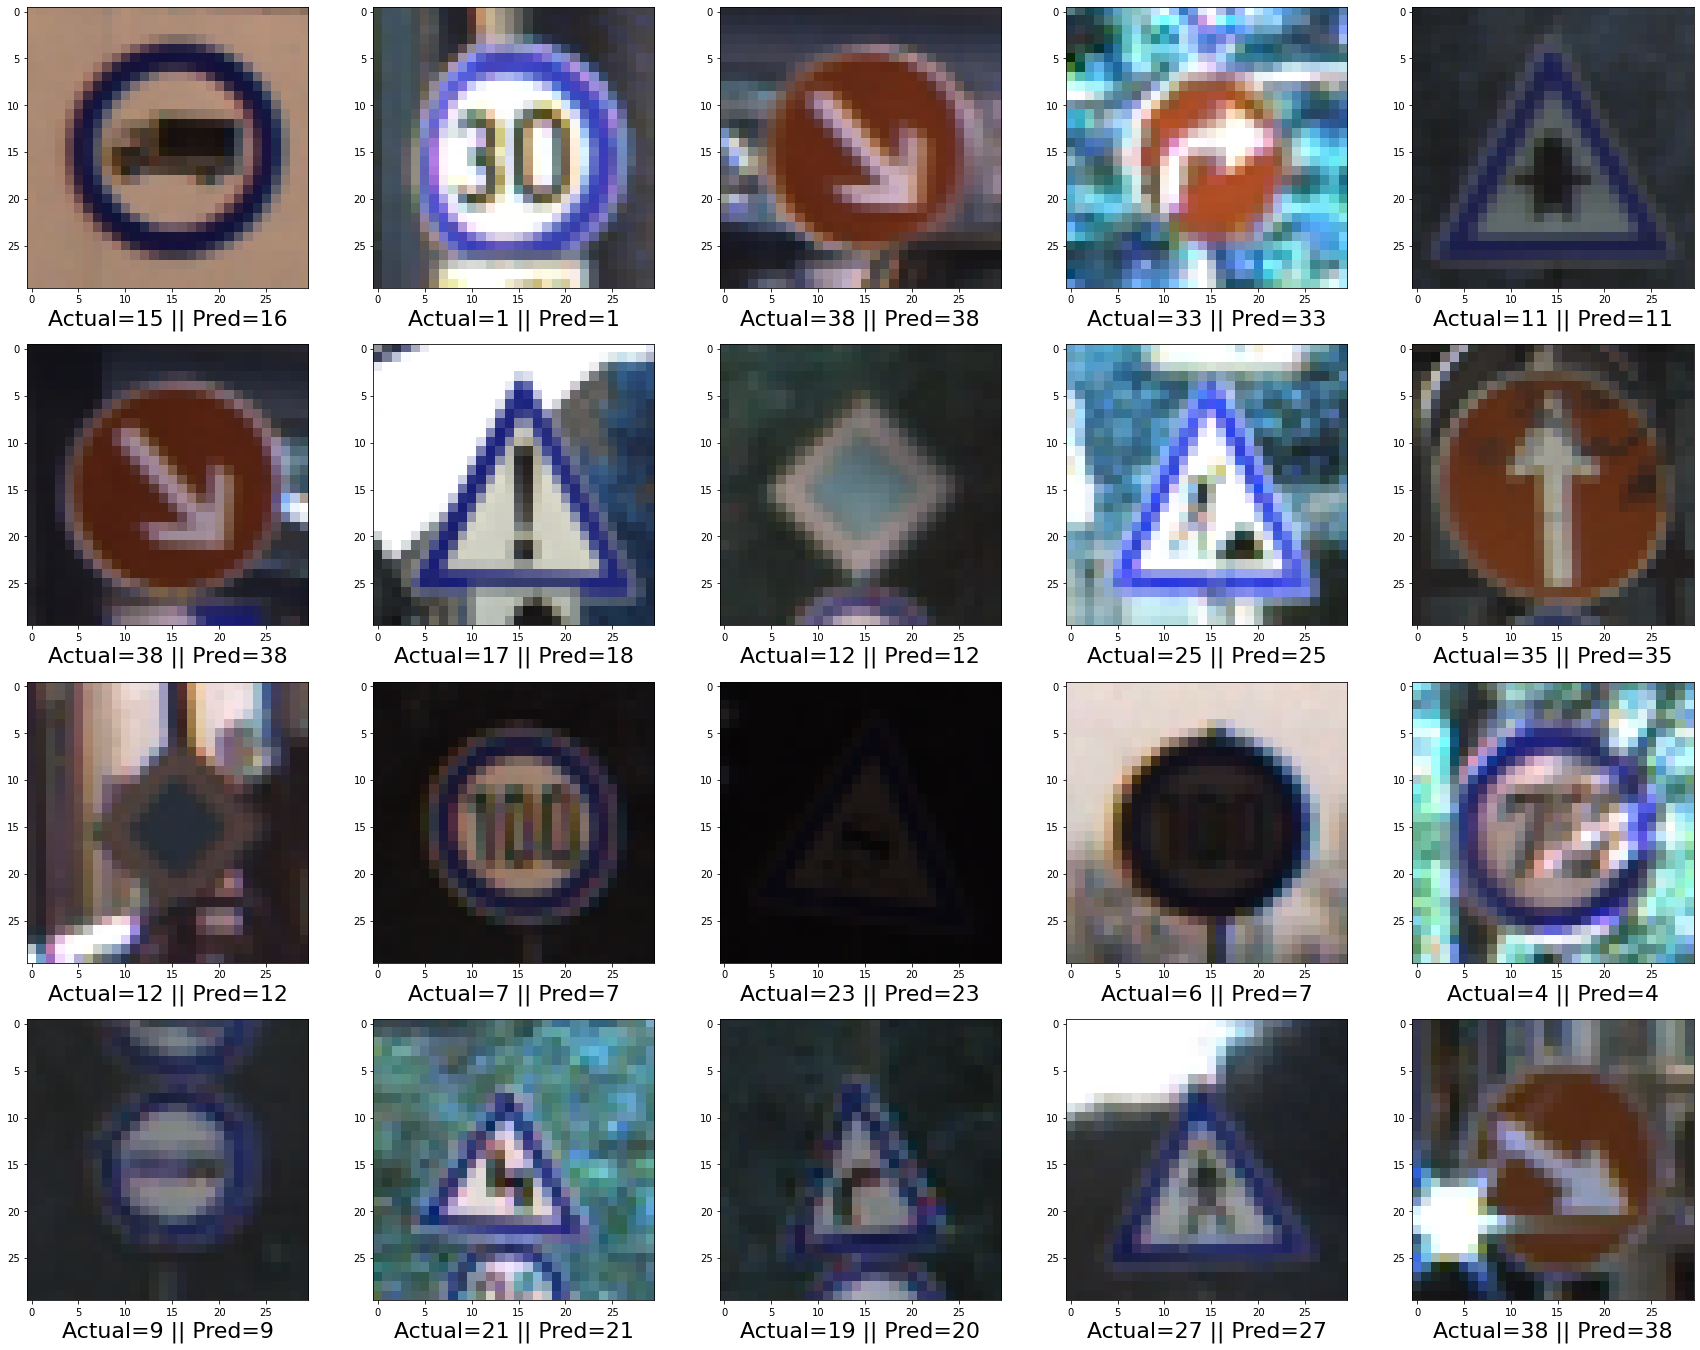

In [ ]:
plt.figure(figsize = (HEIGHT, WIDTH))

start_index = 0
for i in range(20):
    plt.subplot(5, 5, i + 1)
    prediction = test_labels[start_index + i]
    actual = y_predict[start_index + i]
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), fontsize=22)
    plt.imshow(x_test[start_index + i])
plt.show()

As shown in the graph above, although a few of the image predictions differ from the actual, overall the accuracy is high, at 89%。Compared with other models, CNN's accuracy is not the highest, but its speed is very fast. It converges as long as 10 epochs.

## Discussion

The test accuracy of the CNN model is 89% which is a good result, but not nearly good enough. However, the model has the advantage that the time required for training is exceptionally short, requiring only 10 epoches to converge. In order to improve the accuracy, one can try to adjust the parameters and layers in the future to find a better and more appropriate architecture of model.